In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gammaincinv, gammainc, gamma

In [4]:
from convenience_functions import *

# Problem 1: Building a galaxy scene

## [1a] Write down the 2D Sersic Model

First, let's implement a Sersic model of a galaxy. The Sersic profile is written as:

$$ I(x,y) = I_e \exp\left( -b_n\left[ \left( \frac{r(x,y)}{R_{\rm eff}}\right)^{(1/n)} - 1 \right] \right)$$

where $I_e$ is the amplitude of the profile, $n$ the Sersic index, $R_{\rm eff}$ is the effective radius, and $b_n$ is defined such that $\Gamma(2n) = 2\gamma(2n,b_n)$ where $\Gamma(w)$ is the gamma function and $\gamma(w,z)$ is the lower incomplete gamma function.

$r(x,y)$ is our distance metric, defined as:

$$ r(x,y)^2 = (x-x_0)^2 + (y-y_0)^2(1-\epsilon)^{-2}$$

for an ellipticity $\epsilon$ -- you might notice that we're not dealing with rotation here, for simplicity, but rotating the ellipse can be done by transforming $r(x,y)$ given some position angle.

In [84]:
def sersic2d ( x, y, amplitude, n, r_eff, ellip, x_0=None, y_0=None ):
    if x_0 is None:
        x_0 = x.shape[1]//2
    if y_0 is None:
        y_0 = y.shape[0]//2

    x = x-x_0# center x around x_0
    y = y-y_0# center y around y_0
    
    bn = gammaincinv(2.*n, 0.5) # \\ I'm giving you this for free to save you a syntax look-up
    yb = y/((1-ellip))# account for ellipticity given that y is aligned with the semi-minor axis
    rnormed = np.sqrt(x**2+yb**2) # compute the elliptical radius (r(x,y) above)

    value = amplitude*np.exp(-bn*((rnormed/r_eff)**(1/n)-1))# Sersic SB profile
    return value

Another useful metric for this problem set will be the total flux of the Sersic model. Feel free to integrate the profile directly, or use this [analytic solution](https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html):

$$ L_{\rm tot} = I_e R_{\rm eff}^2 2 \pi n \frac{e^{b_n}}{b_n^{2n}} \Gamma(2n),$$

In [200]:
def total_flux ( amplitude, n, r_eff, ellip, **kwargs ):
    # complete
    bn = gammaincinv(2.*n, 0.5)
    tot_flux = amplitude*r_eff**2*2*np.pi*n*np.exp(bn)/(bn**(2*n))*gamma(2*n)*(1-ellip)
    return tot_flux


## [1b] Instantiate our Sersic model
Now that we have an implementation of the 2D Sersic, let's see how it looks for some simulated data.

In [201]:
y,x = np.mgrid[:512,:512]

In [202]:
params_0 = {'amplitude': 10., 'n':1., 'r_eff':30., 'ellip':0.7, 'x_0':350, 'y_0':350}
params_1 = {'amplitude': 1., 'n':2., 'r_eff':30., 'ellip':0.2, 'x_0':200, 'y_0':150}#{'amplitude': 1.,  'n':2., 'r_eff':30., 'ellip':0.2, 'x_0':200, 'y_0':150}

galaxy_0 = sersic2d(x,y, **params_0)
galaxy_1 = sersic2d(x,y, **params_1)

noise = np.random.normal(0., 1., x.shape)

(<matplotlib.image.AxesImage at 0x16b2b0340>, <Axes: >)

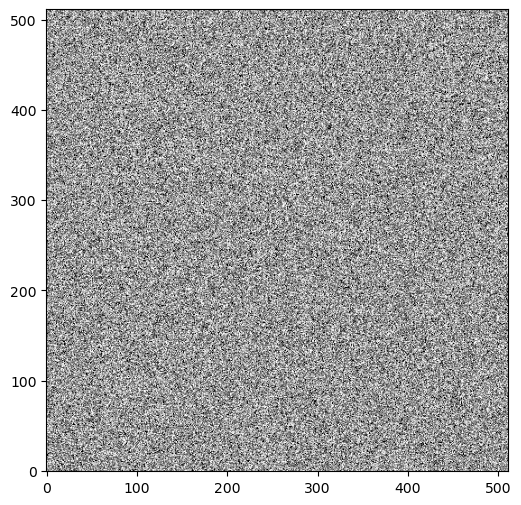

In [203]:
fig, axarr = plt.subplots(1,1,figsize=(6,6))
our_imshow(galaxy_1+noise - apgalaxy_1(x, y))# make a scene with two galaxies and a noisy background

(<matplotlib.image.AxesImage at 0x16b1f1460>, <Axes: >)

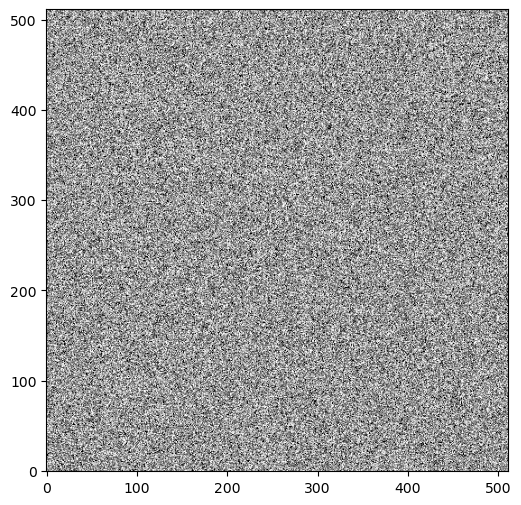

In [204]:
fig, axarr = plt.subplots(1,1,figsize=(6,6))
our_imshow(galaxy_0+noise - apgalaxy_0(x, y))# make a scene with two galaxies and a noisy background

## [1c] Check your work

Astropy also has an implementation of the Sersic2D model -- let's now check our work against the distributed model.

In [205]:
from astropy.modeling.models import Sersic2D 

apgalaxy_0 = Sersic2D(**params_0)
apgalaxy_1 = Sersic2D(**params_1)

In [206]:
# create an assert statement that checks if our model is equivalent to the astropy model
assert np.allclose(galaxy_0, apgalaxy_0(x, y))
assert np.allclose(galaxy_1, apgalaxy_1(x, y))


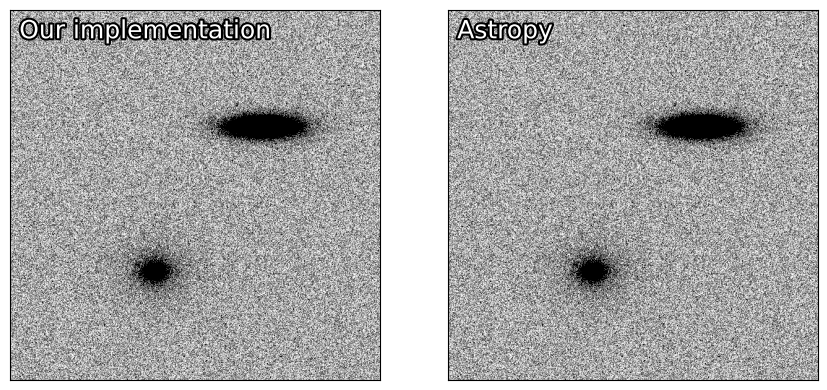

In [207]:
fig, axarr = plt.subplots(1,2,figsize=(9,4))
our_imshow(noise+galaxy_0+galaxy_1, ax=axarr[0])# show our noisy galaxy image
our_imshow(noise+apgalaxy_0(x, y)+apgalaxy_1(x, y), ax=axarr[1])# show the noisy astropy galaxy image

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

our_text(
    0.025,
    0.975,
    'Our implementation',
    fontsize=18,
    color='w',
    bordercolor='k',
    borderwidth=3,
    ax=axarr[0]
)

our_text(
    0.025,
    0.975,
    'Astropy',
    fontsize=18,
    color='w',
    bordercolor='k',
    borderwidth=3,
    ax=axarr[1]
)
plt.tight_layout()

And another way we can check our work is to see if our total flux is what we expect for each galaxy:

In [208]:
print(np.sum(galaxy_0/apgalaxy_0(x, y)/len(galaxy_0)**2))# flux ratio between our galaxy 0 and the astropy galaxy 0
print(np.sum(galaxy_1/apgalaxy_1(x, y))/len(galaxy_0)**2)# same for galaxy 1

# These values should be >0.99!

0.9999999999999989
1.0


Let's also compute the magnitude of these galaxies, assuming that the pixel values are in nanojanskies:

In [209]:
def flux2mag ( flux ):
    return -2.5*np.log10(flux*1e-9/3631)  # magnitude, assuming that pixels are in nJy. Remember that gAB = 3631 Jy!
rmag_0 = flux2mag(total_flux(**params_0))
rmag_1 = flux2mag(total_flux(**params_1))
print(rmag_0, rmag_1)

20.128373219940503 21.225540867619724


# Problem 2: Aperture photometry

Now let's explore what aperture photometry looks like for extended sources. Here we're going to use elliptical apertures of the same shape as the Sersic profiles so that we can make sure our 1Reff aperture recovers half the total light from the galaxy.

## [2a] Construct an elliptical aperture

In [210]:
def build_elliptical_aperture (rmax, x, y, r_eff, ellip, x_0, y_0 ):
    x = x - x_0
    y = y - y_0
    semiminor = r_eff*(1-ellip)# semiminor axis
    ellipse = (x**2/r_eff**2 + y**2/semiminor**2)**0.5# ellipse equation
    # \\ We're just going to make an elliptical mask as our aperture here -- in practice there
    # \\ are more sophisticated ways to do this, but this will serve our purposes here.
    regionauto = ellipse < rmax/r_eff # make a mask that is True only within rmax
    return regionauto

## [2b] Perform elliptical aperture photometry within 1$R_{\rm eff}$

By definition, an elliptical aperture at $R_{\rm eff}$ should capture half the total flux -- let's check that for this case.

(<matplotlib.contour.QuadContourSet at 0x16b41f7f0>, <Axes: >)

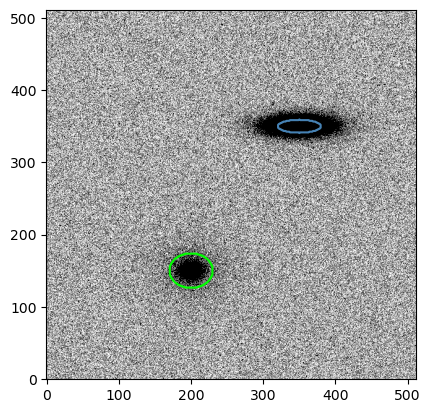

In [211]:
our_imshow(noise+galaxy_0+galaxy_1)# noisy galaxy image

our_contour(build_elliptical_aperture(params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],),
           colors='lime')
our_contour(build_elliptical_aperture(params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],),
           colors='steelblue')

In [212]:
mask_0 = build_elliptical_aperture(params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],)
mask_1 = build_elliptical_aperture(params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],)

In [213]:
# \\ We know that 1Re should contain half the flux of each galaxy -- check this!
print(np.sum(galaxy_0[mask_0])/np.sum(galaxy_0))
print(np.sum(galaxy_1[mask_1])/np.sum(galaxy_1))

0.4953354388693402
0.5027583632856428


## [2c] Perform aperture photometry at $2R_{\rm eff}$

Because $R_{\rm eff}$ is the aperture that contains half the luminosity, a naive guess for a good aperture might be twice that -- let's see how this performs.

(<matplotlib.contour.QuadContourSet at 0x16b523d90>, <Axes: >)

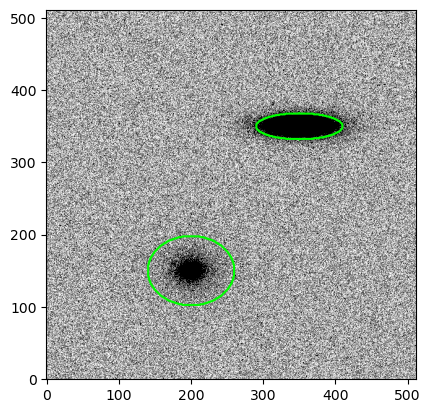

In [217]:
our_imshow(noise+galaxy_0+galaxy_1)# noisy galaxy scene

our_contour(build_elliptical_aperture(2.*params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],),
           colors='lime')
our_contour(build_elliptical_aperture(2.*params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],),
           colors='lime')

In [218]:
mask_0 = build_elliptical_aperture(2.*params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],)
mask_1 = build_elliptical_aperture(2.*params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],)

In [220]:
# now look at the flux fraction contained. Is it higher or lower than what you expected?
print(np.sum(galaxy_0[mask_0])/np.sum(galaxy_0))
print(np.sum(galaxy_1[mask_1])/np.sum(galaxy_1))

0.8470303040353749
0.765961120394715


# Problem 3: Model photometry

## [3a] Fitting a single Sersic

First, let's write a function to fit a single Sersic to the data.

In [155]:
from astropy.modeling.fitting import LevMarLSQFitter

In [156]:
def fit_sersic_2d(
        image, 
        init_n=1., 
        init_r_eff=None, 
        init_ellip=0.5, 
        init_theta=0., 
        init_x_0=None, 
        init_y_0=None, 
        fixed_parameters=None, 
        nan_replace=0.
    ):
    image = np.where(np.isnan(image), nan_replace, image)
    y, x = np.mgrid[:image.shape[0], :image.shape[1]]

    # \\ for these initial parameter guesses, think about what a good starting
    # \\ guess might be assuming that you are dealing with a galaxy that is small(ish)
    # \\ compared to your cutout size
    if init_x_0 is None:
        # what should init_x_0 be if none is supplied?
    if init_y_0 is None:
        # what should init_y_0 be if none is supplied?
    init_amplitude = # what should init_amplitude be if none is supplied?
    
    if init_r_eff is None:        
        init_r_eff = # what should init_r_eff be if none is supplied?

    sersic_init = # initialize Sersic with these parameters
    if fixed_parameters is not None:
        for param in fixed_parameters:
            setattr(getattr(sersic_init, param), 'fixed', True)
                    
                
    sersic_init.bounds.update ({
        # update Sersic bounds as you see fit to converge on a good result
        # consider -- what are the physically plausible bounds for each parameter?
    })
    fitter = # call the fitter

    fitted_model = fitter(sersic_init, x, y, image)
    im = # produce fitted image
    return fitted_model, im

IndentationError: expected an indented block (3412288192.py, line 20)

In [ ]:
mock_image = # make single galaxy noisy image

In [ ]:
bestfit_model, bestfit_image = fit_sersic_2d(# fit your image

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = # make residual image
our_imshow(residual,ax=axarr[2],)
# \\ you should see subtraction that is good to the image noise level here!

With reasonable guesses for the position and effective radius of the source, this does quite well -- as expected. But what if there's another galaxy nearby?

In [ ]:
params_2 = {'amplitude': 10., 'n':1., 'r_eff':60., 'ellip':0.2, 'x_0':300, 'y_0':300}
galaxy_2 = sersic2d(x,y,**params_2)

mock_image = # noisy galaxy scene with galaxy 2 added in addition to galaxy 0

In [ ]:
bestfit_model, bestfit_image = fit_sersic_2d(# fit again)


In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = # make residual
our_imshow(residual,ax=axarr[2],)

Not so great. But what if our model knows that multiple galaxies exist?

## [3b] Fitting multiple models to a single scene

In [ ]:
def fit_multi_sersic_2d(image, init_x_0, init_y_0, dx=0., dy=0., 
                        init_n=None, init_r_eff=None, init_ellip=None, 
                        init_theta=None, init_amplitude=None,
                        fixed_parameters=None, nan_replace=0.):
    """
    Fit multiple Sersic 2D profiles to an image with constrained position variations.
    
    Parameters:
    -----------
    image : array_like
        2D image to fit
    init_x_0 : list or array
        Initial x positions for each Sersic component
    init_y_0 : list or array  
        Initial y positions for each Sersic component
    dx : float, optional
        Maximum allowed variation in x direction from initial positions (default: 0)
    dy : float, optional
        Maximum allowed variation in y direction from initial positions (default: 0)
    init_n : list, array, or float, optional
        Initial Sersic indices. If scalar, same value used for all components (default: 1.0)
    init_r_eff : list, array, or float, optional
        Initial effective radii. If None, estimated from image size (default: None)
    init_ellip : list, array, or float, optional
        Initial ellipticities. If scalar, same value used for all components (default: 0.5)
    init_theta : list, array, or float, optional
        Initial position angles. If scalar, same value used for all components (default: 0.0)
    init_amplitude : list, array, or float, optional
        Initial amplitudes. If None, estimated from image values at positions (default: None)
    fixed_parameters : dict, optional
        Dictionary with component index as key and list of parameter names to fix as values
        e.g., {0: ['n', 'theta'], 1: ['ellip']}
    nan_replace : float, optional
        Value to replace NaNs with (default: 0.0)
        
    Returns:
    --------
    fitted_model : astropy compound model
        The fitted multi-component Sersic model
    model_image : array_like
        2D array of the fitted model evaluated on the image grid
    """
    
    # Handle NaNs
    image = np.where(np.isnan(image), nan_replace, image)
    y, x = np.mgrid[:image.shape[0], :image.shape[1]]
    
    # Convert inputs to lists and validate
    init_x_0 = np.atleast_1d(init_x_0)
    init_y_0 = np.atleast_1d(init_y_0)
    n_components = len(init_x_0)
    
    if len(init_y_0) != n_components:
        raise ValueError("init_x_0 and init_y_0 must have the same length")
    
    def broadcast_param(param, default_val, param_name):
        # most of the parameters can take a scalar (float) OR array-like input
        # write a function to handle the scalar case given that the Sersic
        # initialization will need a vector of length N (where N=number of galaxies)
    
    # Set up parameter lists
    init_n_list = broadcast_param(init_n, 1.0, 'init_n')
    init_ellip_list = broadcast_param(init_ellip, 0.5, 'init_ellip')
    init_theta_list = broadcast_param(init_theta, 0.0, 'init_theta')
    
    # Handle r_eff - estimate if not provided
    if init_r_eff is None:
        default_r_eff = min(image.shape) / 10
        init_r_eff_list = [default_r_eff] * n_components
    else:
        init_r_eff_list = broadcast_param(init_r_eff, min(image.shape) / 10, 'init_r_eff')
    
    # Handle amplitude - estimate from image if not provided
    if init_amplitude is None:
        init_amplitude_list = []
        for i in range(n_components):
            x_idx = # don't let the galaxies run off the cutout
            y_idx = # don't let the galaxies run off the cutout
            init_amplitude_list.append(# what's a good amplitude initialization? )
                # hint: if the initial position guess is correct, what is the amplitude?
    else:
        init_amplitude_list = broadcast_param(init_amplitude, 1.0, 'init_amplitude')
    
    # Create individual Sersic models
    sersic_models = []
    for i in range(n_components):
        sersic = Sersic2D(
            # initialize galaxy i
        )
        
        # Set bounds for this component
        sersic.bounds.update({
            # set bounds for galaxy i
        })
        
        # Apply fixed parameters if specified
        if fixed_parameters is not None and i in fixed_parameters:
            for param in fixed_parameters[i]:
                setattr(getattr(sersic, param), 'fixed', True)
        
        sersic_models.append(sersic)
    
    # Create compound model
    if n_components == 1:
        compound_model = # complete
    else:
        compound_model = sersic_models[0]
        for i in range(1, n_components):
            compound_model = # add each model to create a compound model
    
    # Fit the model
    fitter = LevMarLSQFitter()
    fitted_model = # do fitting
    
    # Generate model image
    model_image = # get fitted image
    
    return fitted_model, model_image


Now let's try re-fitting the same scene

In [ ]:
params_2 = {'amplitude': 10., 'n':1., 'r_eff':60., 'ellip':0.2, 'x_0':300, 'y_0':300}
galaxy_2 = sersic2d(x,y,**params_2)

mock_image = galaxy_0 + galaxy_2 + noise

In [ ]:
bestfit_model, bestfit_image = fit_multi_sersic_2d(
    mock_image, 
    init_x_0=# feed in initial positions
    init_y_0=# feed in initial positions
    init_r_eff=[30.,60.],
    fixed_parameters=('x_0','y_0')
)


In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = # make residual
our_imshow(residual,ax=axarr[2],)

## [3c] Challenge problem: probabilistically fit a scene of galaxies without prior knowledge of the number or properties of galaxies in the scene

# Problem 4: Multiband photometry

If you have all of the above notebook working, try convolving your galaxies with a Gaussian PSF to explore the effects of variations in image quality. In particular:

In [ ]:
from scipy.ndimage import convolve

## [4a] False color gradients

First, let's see what happens if we have two different PSFs and we just subtract out one from the other.

In [ ]:
def gaussian2d(x, y, A, m, s):
    '''
    2D axisymmetric Gaussian
    
    Parameters:
    -----------
    x, y : array-like
        Coordinate arrays
    A : float or 'normalize'
        Amplitude (or 'normalize' for unit integral)
    m : array-like
        Center coordinates
    s : float
        Standard deviation (same for both x and y)
    '''
    if A == 'normalize':
        A = 1.0 / (2 * np.pi * s**2)
    
    # Radial distance from center
    r_squared = (x - m[0])**2 + (y - m[1])**2
    
    return A * np.exp(-r_squared / (2 * s**2))

In [ ]:
psf_size = 65
pc = (psf_size-1)//2
psf_y,psf_x = np.mgrid[:psf_size,:psf_size]

f_std = 2.
g_std = 10.

f_psf = gaussian2d(psf_x,psf_y,'normalize',(pc,pc),f_std)
g_psf = gaussian2d(psf_x,psf_y,'normalize',(pc,pc),g_std)

In [ ]:
y,x = np.mgrid[:512,:512]
sxy = # make galaxy

In [ ]:
g_img = # make g PSF - convolved image
f_img = # maek f PSF-convolved image

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(f_img, ax=axarr[0])
our_imshow(g_img, ax=axarr[1])
residual = # residual
axarr[2].imshow(residual, cmap='coolwarm_r', vmin=-2., vmax=2, origin='lower')

## [4b] A Gaussian matching kernel

Here, we're going to take advantage of the fact that the convolution of two Gaussians is a Gaussian to get an analytic solution to our matching kernel and avoid a lot of the numerical instability often found in PSF matching.

In [ ]:
def gaussian_matching_kernel(sigma1, sigma2, size):
    """Create Gaussian matching kernel to convolve sigma1 PSF to sigma2 PSF"""
    if sigma2 <= sigma1:
        raise ValueError("Cannot improve seeing: sigma2 must be > sigma1")
    
    sigma_kernel = # What's the standard deviation of a convolution of two Gaussians?

    x, y = np.meshgrid(np.arange(size) - size//2, np.arange(size) - size//2)
    kernel = # What's the kernel, knowing that it's also a Gaussian in form?
    kernel /= np.sum(kernel)  # normalize
    
    return kernel

In [ ]:
matching_kernel = gaussian_matching_kernel(f_std, g_std, f_psf.shape[0])

In [ ]:
f_img_convolved = convolve(f_img, matching_kernel)

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(f_img_convolved, ax=axarr[0])
our_imshow(g_img, ax=axarr[1])
residual_matched = # get residual
axarr[2].imshow(residual_matched, cmap='coolwarm_r', vmin=-2., vmax=2, origin='lower')